## Checking Radler Waveform (seed 1911)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

from scipy import signal
from astropy.constants import G,c,M_sun

from LISAhdf5 import LISAhdf5,ParsUnits,Str
import LISAConstants as LC
from LISACommonFunctions import *
import psd,tdi

FigSize = [10,7]

In [3]:
#DirLDC = '/Users/petiteau/Applications/LDC/LDC/'
DirLDC = '/codes/LDC/'
DirScript = DirLDC+'software/LDCpipeline/scripts/'

Locate the relevant .hdf5 file!!!

In [4]:
#Load hdf5 file
Lh = LISAhdf5('MBHB_RadlerTest_seed1911_TD_NoNoise.hdf5')
Lh.getSourcesName()

['MBHB-0']

In [5]:
#Get GW source name and parameters
file=Lh.getSourceParameters('MBHB-0')
file.get('Cadence'),file.get('ObservationDuration')
file.display()

#Get the time series
thphc = Lh.getSourceHpHc('MBHB-0')

	Approximant IMRPhenomD [ModelName]
	AzimuthalAngleOfSpin1 5.05978711159 [Radian]
	AzimuthalAngleOfSpin2 1.68114770642 [Radian]
	Cadence 10.0 [Seconds]
	CoalescenceTime 24960000.0 [Second]
	Distance 56.0057836629 [Gpc]
	EclipticLatitude 0.292696326795 [Radian]
	EclipticLongitude 3.5091 [Radian]
	InitialAzimuthalAngleL 5.99502819295 [Radian]
	InitialPolarAngleL 1.8554 [Radian]
	Mass1 2599137.035 [SolarMass]
	Mass2 1242860.685 [SolarMass]
	ObservationDuration 41943040.0 [Seconds]
	PhaseAtCoalescence 2.1039585762 [Radian]
	PolarAngleOfSpin1 0.0 [Radian]
	PolarAngleOfSpin2 0.0 [Radian]
	Redshift 5.7309 [dimensionless]
	Spin1 0.753482185706 [MassSquared]
	Spin2 0.621587527964 [MassSquared]



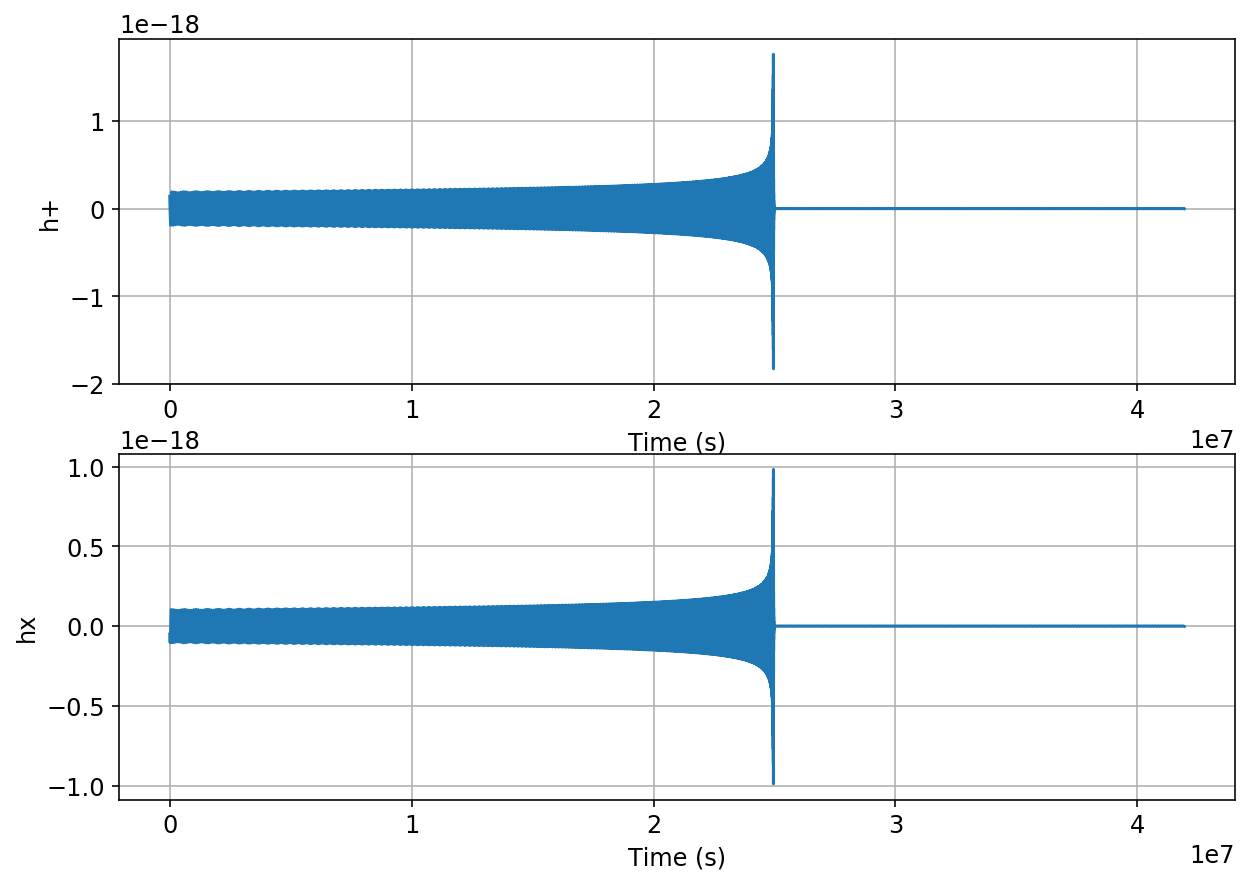

In [6]:
#Plot the timeseries
fig,(ax1,ax2)=plt.subplots(2,1,figsize=FigSize)
ax1.plot(thphc[:,0],thphc[:,1])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('h+')
ax1.grid()

ax2.plot(thphc[:,0],thphc[:,2])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('hx')
ax2.grid()

plt.show()

### Fourier transform and Power spectral density

In [7]:
samp_time,tot_time=file.get('Cadence'),file.get('ObservationDuration')
# Sample points in the frequency domain
f = np.fft.rfftfreq(thphc.shape[0], d=thphc[1,0]-thphc[0,0])

In [8]:
# Perform an FFT on h+ and hx
fhphc=np.column_stack([f,np.fft.rfft(thphc[:,1]),np.fft.rfft(thphc[:,2])])

#Compute the PSD via Welch method
fs = 1/file.get('Cadence')
nfft=thphc.shape[0]

freq, Pden_p = signal.welch(thphc[:,1], fs, scaling='density',nperseg=int(fs/1e-6),window='blackman')
freq, Pden_c = signal.welch(thphc[:,2], fs, scaling='density',nperseg=int(fs/1e-6),window='blackman')

We are expecting, given masses and redshift

In [9]:
M1,M2,z=file.get('Mass1'),file.get('Mass2'),file.get('Redshift')
M1,M2,z

(2599137.0350000001, 1242860.6850000001, 5.7309000000000001)

In [10]:
def freq_isco(m):
    return c**3/(G*M_sun*m*(6*np.sqrt(6))*np.pi)

A $f_{ISCO}$ (neglecting spin, first order in symmetric mass ratio) approximately 

$$f^{obs}_{ISCO}=\frac{1}{1+z} \frac{1}{(6\sqrt{6})\pi}\frac{c^3}{GM} \\
 \simeq 4.4 \textrm{ mHz } \left(\frac{10^6 M_{\odot}}{M}\right)\left(\frac{1}{1+z}\right)
$$

In [11]:
fisco=freq_isco(M1+M2)/(1+z)
fisco

<Quantity 0.00017003702009825224 1 / s>

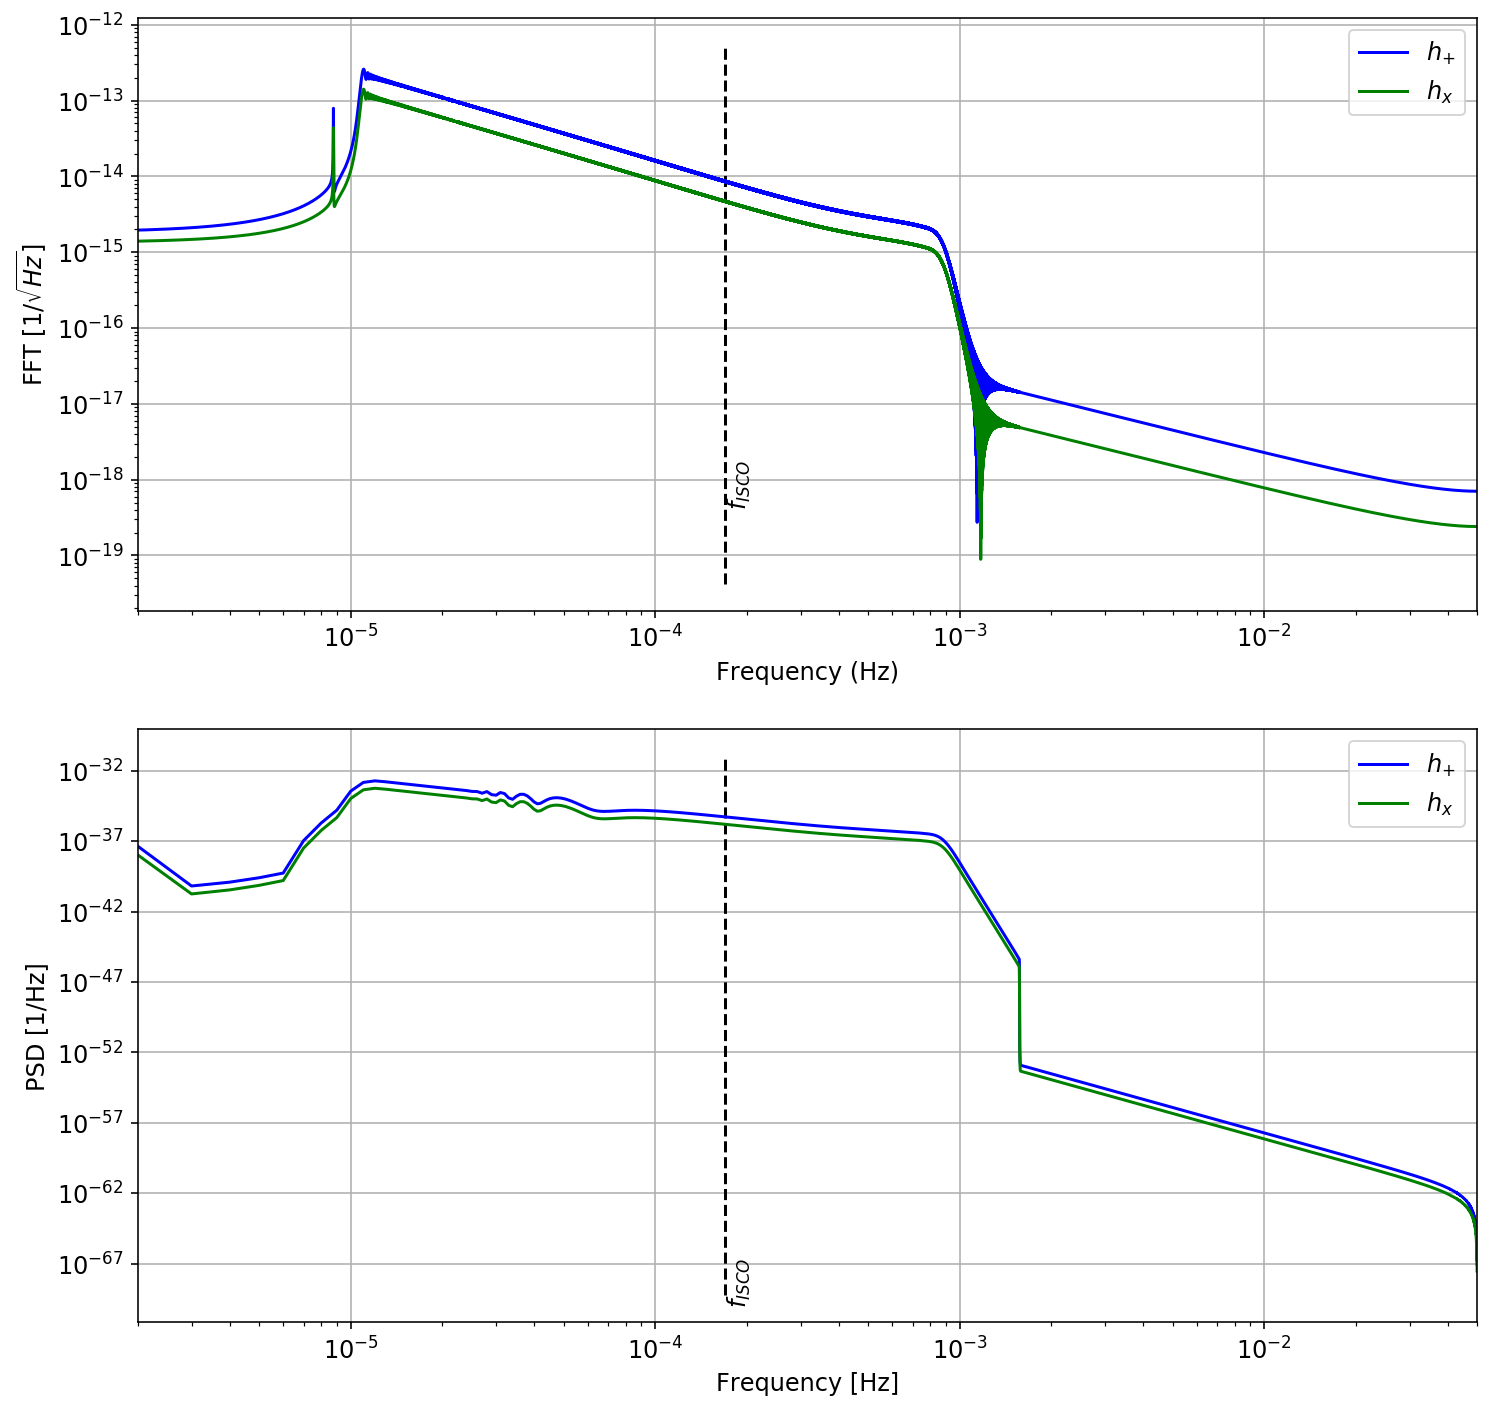

In [12]:
# Creating some custom subplots
FigSize=(12,12)
fg, (ax1,ax2) = plt.subplots(2,1, figsize=FigSize)

# Plot FFT, PSD and f_ISCO

ax1.loglog(np.abs(fhphc[:,0]), np.abs(fhphc[:,1]) * samp_time, 'b-', label=r'$h_{+}$')
ax1.loglog(np.abs(fhphc[:,0]), np.abs(fhphc[:,2]) * samp_time, 'g-', label=r'$h_{x}$')
ax1.vlines(fisco.value,ymin=ax1.get_ylim()[0],ymax=ax1.get_ylim()[1],linestyles="dashed")
ax1.text(fisco.value,1e-18,r'$f_{ISCO}$',rotation=90)
ax1.grid()
ax1.set_xlim(2e-6,5e-2)
ax1.set_xlabel(r'Frequency (Hz)')
ax1.set_ylabel(r'FFT [$1/\sqrt{Hz}$]')
ax1.legend()


ax2.loglog(freq, Pden_p,'b-',label=r'$h_{+}$')
ax2.loglog(freq, Pden_c,'g-',label=r'$h_{x}$')
ax2.vlines(fisco.value,ymin=ax2.get_ylim()[0],ymax=ax2.get_ylim()[1],linestyles="dashed")
ax2.text(fisco.value,1e-68,r'$f_{ISCO}$',rotation=90)
ax2.grid()
ax2.set_xlim(2e-6,5e-2)
ax2.set_xlabel(r'Frequency [Hz]')
ax2.set_ylabel('PSD [1/Hz]')
ax2.legend()

fig.tight_layout()
plt.show()

## Time to coalescence

Compute the initial frequency

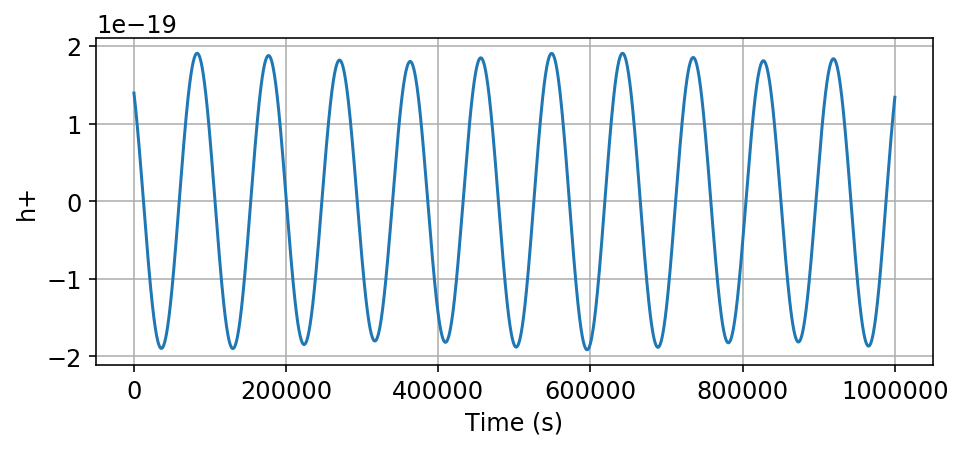

In [13]:
thphc = Lh.getSourceHpHc('MBHB-0')

#Taking a small chunk to determine the initial frequency
M=100000

fig,ax1=plt.subplots(1,1,figsize=(7.5,3))
ax1.plot(thphc[0:M,0],thphc[0:M,1])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('h+')
ax1.grid()
plt.show()

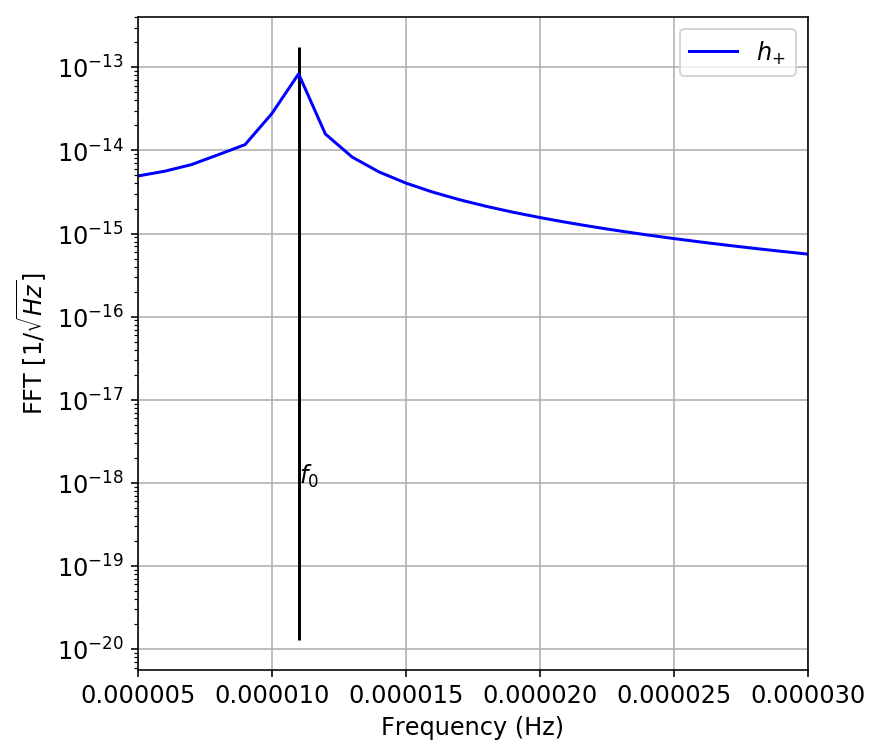

In [14]:
samp_time,tot_time=file.get('Cadence'),file.get('ObservationDuration')

# Sample points in the frequency domain
f = np.fft.rfftfreq(M, d=thphc[1,0]-thphc[0,0])

# Get peak frequency from a small chunk
fhphc=np.column_stack([f,np.fft.rfft(thphc[0:M,1]),np.fft.rfft(thphc[0:M,2])])
f0=np.abs(fhphc[np.argmax(np.abs(fhphc[0:M,2])),0])

# Creating some custom subplots
FigSize=(6,6)
fg,ax1 = plt.subplots(1,1, figsize=FigSize)
ax1.semilogy(np.abs(fhphc[0:M,0]), np.abs(fhphc[0:M,1]) * samp_time, 'b-', label=r'$h_{+}$')
ax1.vlines(f0,ymin=ax1.get_ylim()[0],ymax=ax1.get_ylim()[1])
ax1.text(f0,1e-18,r'$f_0$')
ax1.grid()
ax1.set_xlim(5e-6,3e-5)
ax1.set_xlabel(r'Frequency (Hz)')
ax1.set_ylabel(r'FFT [$1/\sqrt{Hz}$]')
ax1.legend()
fig.tight_layout()
plt.show()

In [26]:
#Defining expected spectrograms
def Chirp(m1,m2):
    return ((m1*m2)**(3/5))/((m1+m2)**1/5)

A=(1/np.pi)*((5/256)**(3/8))*(G*(1+z)*Chirp(M1,M2)*M_sun/(c**3))**(-5/8)

def freqSweep(t,t_coal):
    return A.value/((t_coal-t)**(3/8))

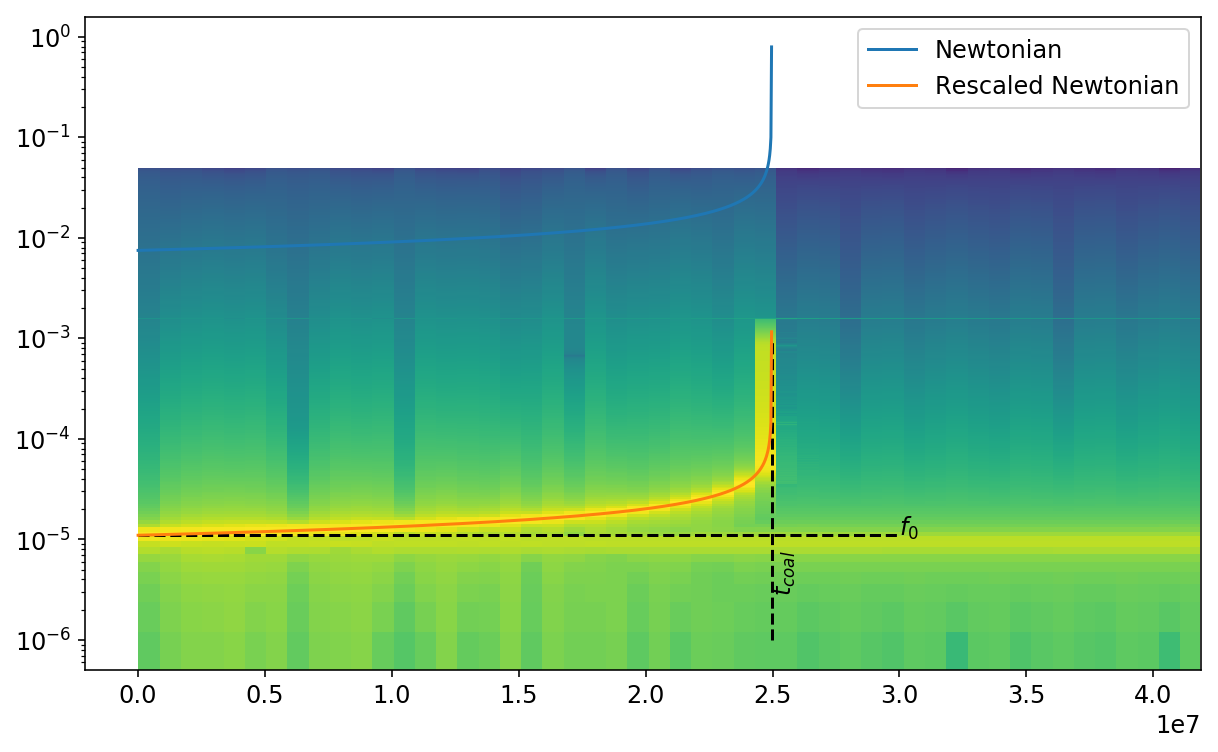

In [27]:
tcoal=file.get('CoalescenceTime')

C=f0/freqSweep(0,tcoal)

N=len(thphc[:,0])
NFFT = int(N/50)


plt.figure(1,figsize=(10,6))
spec_power, freqs, bins, im = plt.specgram(thphc[0:N,1], NFFT=NFFT, Fs=1/10.,sides='onesided')
time=np.linspace(0.0,tcoal-100.0,1000)
val=freqSweep(time,tcoal)
#plt.ylim(1e-6,5e-4)
plt.yscale('log')
plt.vlines(tcoal,1e-6,1e-3,linestyle='dashed')
plt.text(tcoal,5e-6,r'$t_{coal}$',rotation=90)
plt.hlines(np.abs(f0),0,3e7,linestyle='dashed')
plt.text(3e7,np.abs(f0),r'$f_{0}$')
plt.plot(time,val, label='Newtonian')
plt.plot(time,C*val,label='Rescaled Newtonian')
plt.legend()
plt.show()

TODO...include mass ratio correction (is the waveform non spinning)